In [1]:
import pandas as pd
import tensorflow as tf
import classification_utils
import numpy as np
import math

2022-11-28 18:37:18.417817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 18:37:18.583461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 18:37:18.583485: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-28 18:37:19.457773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
df = pd.read_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv")

We are going to use only the numerical attributes, except for the bot column that is the target one

In [3]:
df = df[[
#    "user_id"  ,
#    "name"  ,
#    "lang"  ,
    "bot"  ,
#    "created_at" ,
    "statuses_count" ,
    "account_age_in_days" ,
    "number_of_tweets" ,
    "account_average_tweets_per_day" ,
    "avg_tweets_per_actual_day" ,
#    "day_with_most_tweets" ,
    "max_number_of_tweets_in_a_day",
    "entropy_for_day",
    "entropy_for_hour",
    "entropy_for_minute",
    "avg_hashtags",
    "avg_text_length",
    "avg_mentions",
    "avg_special_char_in_text",
    "total_likes",
    "avt_favorite_count",
    "total_replies",
    "avt_reply_count",
    "total_retweet_count",
    "account_discussion_creation_ratio",
    "tweet_num_likes_ratio",
    "tweet_num_replies_ratio",
    "entropy_original_text",
    "entropy_text",
    "mean_inactive_period_length_in_seconds",
    "median_inactive_period_length_in_seconds",
    "mode_inactive_period_length_in_seconds",
    "mode_count"
]]

In the next 3 lines we shuffle the data in order to avoid biases if for example all the bot are in the bottom part and they will be part only of the test set, then we split the bot column from the other ones and convert them to a tensor 

In [4]:
df = df.sample(frac=1, random_state=1).reset_index()
target_array = tf.convert_to_tensor(df.pop("bot"))
feature_matrix = tf.convert_to_tensor(df)

2022-11-28 18:37:20.518512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-28 18:37:20.518538: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 18:37:20.518559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mpc): /proc/driver/nvidia/version does not exist
2022-11-28 18:37:20.518916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We split the data in training, validation and test.
The training data are the only ones used to fit the neural network, the expactation is that the classification error on this set will only decrease durning the training.

The validation data are used to itaratively evaluate the network and select the best architecture, if the classification error on the validation set increases, it means that the network is in overfit.

The test set is used only after the choise of the final model and is used to have an idea of the error of the network on completely new data

In [5]:
tr_size = 0.7
vl_size = 0.2
ts_size = 0.1

tr_index = round(len(feature_matrix) * tr_size)
vl_index = tr_index + round(len(feature_matrix) * vl_size)
ts_index = vl_index + round(len(feature_matrix) * ts_size)

feature_matrix_tr = feature_matrix[0:tr_index]
target_array_tr = target_array[0:tr_index]

feature_matrix_vl = feature_matrix[tr_index:vl_index]
target_array_vl = target_array[tr_index:vl_index]

feature_matrix_ts = feature_matrix[vl_index:ts_index]
target_array_ts = target_array[vl_index:ts_index]

The choose of the neural network architecture is guided by the theory: since we already have processed features (and not row data), and there is no sign of a hierarchy of features to exploit with the inductive bias of a deep neural network (as for the image classification), we choose to adopt a shallow model, with only one hiddel layer.

https://www.deeplearningbook.org/

https://www.nature.com/articles/nature14539

In the input layer we normalize the data

/home/matteo/.local/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


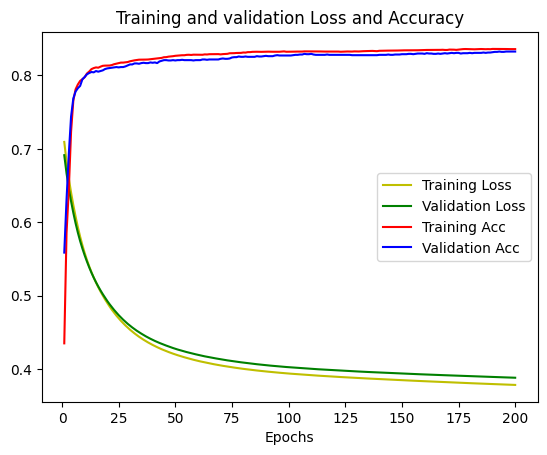

In [6]:
in_layer = tf.keras.layers.Normalization(axis=-1)
in_layer.adapt(feature_matrix_tr)

model = tf.keras.models.Sequential([
  in_layer,
  tf.keras.layers.Dense(64, activation='sigmoid'),   
  tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"]
)

history = model.fit(
  feature_matrix_tr,
  target_array_tr,
  batch_size=2048,
  epochs=200,
  validation_data=(feature_matrix_vl, target_array_vl),
  shuffle=True,
  verbose=False
)

classification_utils.print_training_stats(history=history)

As you can see, we are able to achive a really good accuracy (near 85%), without overfitting 

As a counter example,in the following picture we want to demostrate that a larger nework is able to achive a near 100% accuracy, but then the generalization capabilities are really low because of overfitting, infact the classification error on the validation begin to increase.

We moved the code on anothe file for clarity. The network has 5 hiddel layers with 512 neurons for each layer

/home/matteo/.local/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


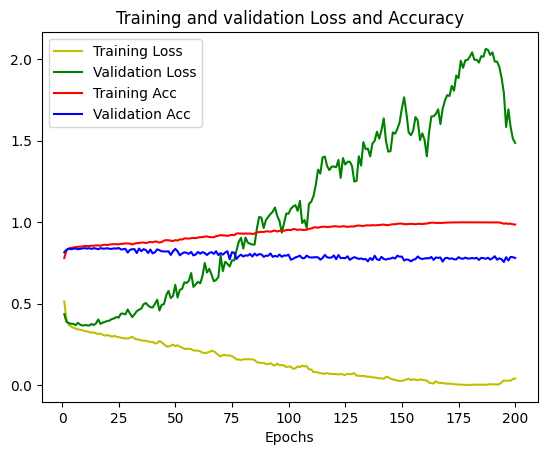

In [7]:
classification_utils.large_model_example(
    feature_matrix_tr,
    target_array_tr,
    feature_matrix_vl,
    target_array_vl
    )

Finally we evaluate the model on completely unseen data, this is like to predict if a new user is a bot or not, i.e. the final objective of the task

35/35 [==============================] - 0s 1ms/step
Test set: 906 correct over 1111 
Accuracy in test: 0.8154815481548154


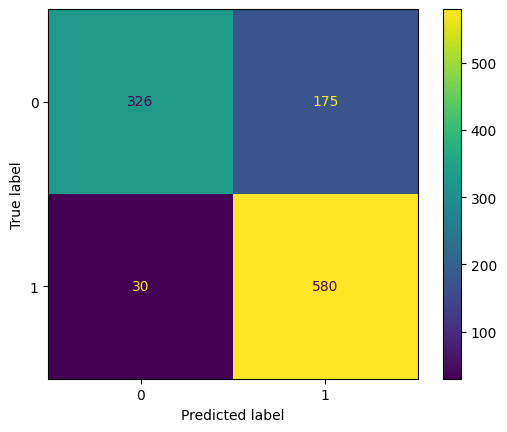

In [8]:
test_predict = (model.predict(feature_matrix_ts) > 0.5).astype("bool")
correct = 0
for (pred, expected) in zip(test_predict, target_array_ts):
    if pred == expected:
        correct +=1
print("Test set:", correct , "correct over", len(test_predict), "\nAccuracy in test:", correct/len(test_predict))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_array_ts, test_predict)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The model seems very good at indentify true bots, while has a little bias to classify real users as boot too (false positive)